# COVID-19 Analysis in Europe

## __Table of Contents__

[1. Load COVID-19 data](#one)

[2. Europe analysis](#two)

[3. Feature selection (Struggle)](#three)

[4. Clustering with quality of life index](#four)



In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from math import log
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tslearn as ts
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

import sklearn as sks
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

import warnings

warnings.filterwarnings('ignore')

/Users/ihoney/.pyenv/versions/3.7.8/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ihoney/.pyenv/versions/3.7.8/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
# Default seaborn setting
sns.set(rc={'figure.figsize':(12,12)})

### 1. Load COVID-19 data<a id='one'>

In [4]:
covid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', na_values='NaN')
# covid = pd.read_csv('../data/external/owid-covid-data.csv', na_values='NaN')

In [5]:
covid.shape

(61054, 50)

In [6]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61054 entries, 0 to 61053
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso_code                            60735 non-null  object 
 1   continent                           60415 non-null  object 
 2   location                            61054 non-null  object 
 3   date                                61054 non-null  object 
 4   total_cases                         52314 non-null  float64
 5   new_cases                           60930 non-null  float64
 6   new_cases_smoothed                  59974 non-null  float64
 7   total_deaths                        44412 non-null  float64
 8   new_deaths                          60930 non-null  float64
 9   new_deaths_smoothed                 59974 non-null  float64
 10  total_cases_per_million             52010 non-null  float64
 11  new_cases_per_million               60611

In [7]:
covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-01-23,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-24,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-25,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-26,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-27,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [8]:
# Check the available continents
covid['continent'].unique()

array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania', nan], dtype=object)

In [9]:
# Select only non-null rows on the Continent column
covid = covid[covid['continent'].notna()]

In [10]:
covid_africa = covid[covid['continent'] == 'Africa']
covid_asia = covid[covid['continent'] == 'Asia']
covid_europe = covid[covid['continent'] == 'Europe']
covid_north = covid[covid['continent'] == 'North America']
covid_south = covid[covid['continent'] == 'South America']
covid_oceania = covid[covid['continent'] == 'Oceania']

## 2. Europe analysis <a id='two'>

In [11]:
covid_europe['location'].unique()

array(['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macedonia', 'Malta', 'Moldova', 'Monaco', 'Montenegro',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican'],
      dtype=object)

In [12]:
len(covid_europe['location'].unique())

46

__Hypothesis:__ We should be able to cluster the European countries by their Human Development Index, GDP per Capita, Population, Life exepectancy, Extreme poverty, Stringency Index.

In [13]:
covid_europe.groupby(['location']).agg({'human_development_index':'max', 'gdp_per_capita':'max', 'population':'max', 'life_expectancy':'max', 'extreme_poverty':'max', 'stringency_index':'mean'}).reset_index().sort_values(['human_development_index','life_expectancy'], ascending=False)

,location,human_development_index,gdp_per_capita,population,life_expectancy,extreme_poverty,stringency_index
31,Norway,0.953,64800.057,5421242.0,82.40,0.2,40.546095
42,Switzerland,0.944,57410.166,8654618.0,83.78,NaN,43.320863
18,Ireland,0.938,67335.293,4937796.0,82.30,0.2,59.029185
14,Germany,0.936,45229.245,83783945.0,81.33,NaN,53.241891
17,Iceland,0.935,46482.958,341250.0,82.99,0.2,40.949154
41,Sweden,0.933,46949.283,10099270.0,82.80,0.5,48.695719
30,Netherlands,0.931,48472.545,17134873.0,82.28,NaN,50.402332
10,Denmark,0.929,46682.515,5792203.0,80.90,0.2,47.900863
44,United Kingdom,0.922,39753.244,67886004.0,81.32,0.2,59.219329
12,Finland,0.920,40585.721,5540718.0,81.91,NaN,38.783548


__Drop names that are not relly countries__

In [14]:
not_countries = ['Andorra', 'Liechtenstein', 'Monaco', 'San Marino', 'Vatican', 'Kosovo']
covid_europe = covid_europe[~covid_europe['location'].isin(not_countries)]
covid_europe['location'].unique()

array(['Albania', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
       'Latvia', 'Lithuania', 'Luxembourg', 'Macedonia', 'Malta',
       'Moldova', 'Montenegro', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'],
      dtype=object)

__Impute null values__

In [15]:
imp_mf = SimpleImputer(strategy='most_frequent')
imp_zero = SimpleImputer(strategy='constant', fill_value=0)

In [16]:
extreme_poverty_imputed = covid_europe.loc[:,'extreme_poverty'].reset_index()
extreme_poverty_imputed = imp_mf.fit_transform(extreme_poverty_imputed).tolist()
extreme_poverty_imputed = [row[1] for row in extreme_poverty_imputed]

covid_europe['extreme_poverty_imputed'] = extreme_poverty_imputed

In [17]:
covid_europe[covid_europe['stringency_index'].isnull()][['location','date']]['location'].unique()

array(['Albania', 'Austria', 'Bosnia and Herzegovina', 'Cyprus',
       'Denmark', 'Finland', 'Germany', 'Greece', 'Hungary', 'Italy',
       'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Moldova',
       'Montenegro', 'Netherlands', 'Norway', 'Portugal', 'Russia',
       'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Ukraine', 'United Kingdom'], dtype=object)

In [18]:
stringency_index_imputed = covid_europe.loc[:,'stringency_index'].reset_index()
stringency_index_imputed = imp_zero.fit_transform(stringency_index_imputed).tolist()
stringency_index_imputed = [row[1] for row in stringency_index_imputed]

covid_europe['stringency_index_imputed'] = stringency_index_imputed

In [19]:
covid_europe.isnull().sum()

iso_code                                  0
continent                                 0
location                                  0
date                                      0
total_cases                            1275
new_cases                                 0
new_cases_smoothed                      200
total_deaths                           2101
new_deaths                                0
new_deaths_smoothed                     200
total_cases_per_million                1275
new_cases_per_million                     0
new_cases_smoothed_per_million          200
total_deaths_per_million               2101
new_deaths_per_million                    0
new_deaths_smoothed_per_million         200
reproduction_rate                      2454
icu_patients                           8318
icu_patients_per_million               8318
hosp_patients                          7342
hosp_patients_per_million              7342
weekly_icu_admissions                 12342
weekly_icu_admissions_per_millio

## 3. Feature selection (Struggle)<a id='three'>

In [49]:
# feature selection
def select_features(X_train, y_train):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_regression, k=3)
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    # transform train input data
    X_train_fs = fs.transform(X_train)

    return X_train_fs, fs


# feature selection
X_train_fs, fs = select_features(covid_europe_X, covid_europe_y)
# fit the model
X = sm.add_constant(X_train_fs)
model = sm.OLS(covid_europe_y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cluster   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     16.15
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           8.17e-07
Time:                        16:48:13   Log-Likelihood:                -64.150
No. Observations:                  40   AIC:                             136.3
Df Residuals:                      36   BIC:                             143.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6250      0.703     10.845      0.000       6.199       9.051
x1         -4.212e-05   1.16e-05     -3.639      0.001   -6.56e-05   -1.86e-05
x2         -3.069e-08   7.28e-09     -4.215      0.000   -4.55e-08   -1.59e-08
x3            -0.0328      0.014     -2.325      0.026      -0.061      -0.004
==============================================================================
Omnibus:                       15.535   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.178
Skew:                           0.121   Prob(JB):                        0.204
Kurtosis:                       1.641   Cond. No.                     1.22e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
cols = fs.get_support(indices=True)
features = covid_europe_X.iloc[:,cols]
features

,gdp_per_capita,population,stringency_index_imputed
location,,,
Norway,64800.057,5421242.0,40.037680
Switzerland,57410.166,8654618.0,42.506050
Ireland,67335.293,4937796.0,59.029185
Germany,45229.245,83783945.0,52.073574
Iceland,46482.958,341250.0,40.949154
Sweden,46949.283,10099270.0,47.779812
Netherlands,48472.545,17134873.0,49.454326
Denmark,46682.515,5792203.0,46.999906
United Kingdom,39753.244,67886004.0,58.105486


# 4. Clustering with quality of life index<a id='four'>

__New task: Cluster the countries by their quality of life index__

In [52]:
covid_europe_class = pd.read_csv('../data/raw/covid_europe_classification.csv')
covid_europe_class = covid_europe_class.set_index('location')

In [53]:
covid_europe.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
     

In [54]:
covid_europe_ts = covid_europe[['location','date','new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']]
covid_europe_ts['date']= pd.to_datetime(covid_europe_ts['date'])
covid_europe_ts = covid_europe_ts.pivot(index='location', columns='date', values='new_cases_per_million')
covid_europe_ts = covid_europe_ts.rolling(7, axis=1, min_periods=1).mean().fillna(0)

In [55]:
model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=1)
X = to_time_series_dataset(covid_europe_ts.copy())
labels = model.fit_predict(X)

In [56]:
location_cluster = {'location': covid_europe_ts.index, 'predicted_cluster': 1 + labels}
location_cluster = pd.DataFrame(location_cluster)
location_clusters = location_cluster.set_index('location').join(covid_europe_class)
location_clusters = location_clusters.reset_index()

<AxesSubplot:xlabel='quality_of_life_label', ylabel='family_tree_label'>

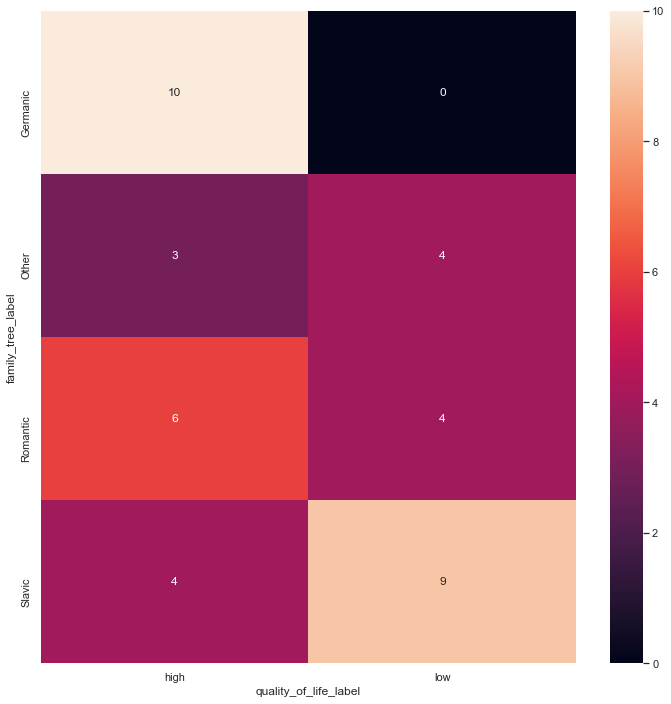

In [57]:
ct_cluster = pd.crosstab(index=location_clusters['family_tree_label'], columns=location_clusters['quality_of_life_label'])
sns.heatmap(ct_cluster, annot = True)

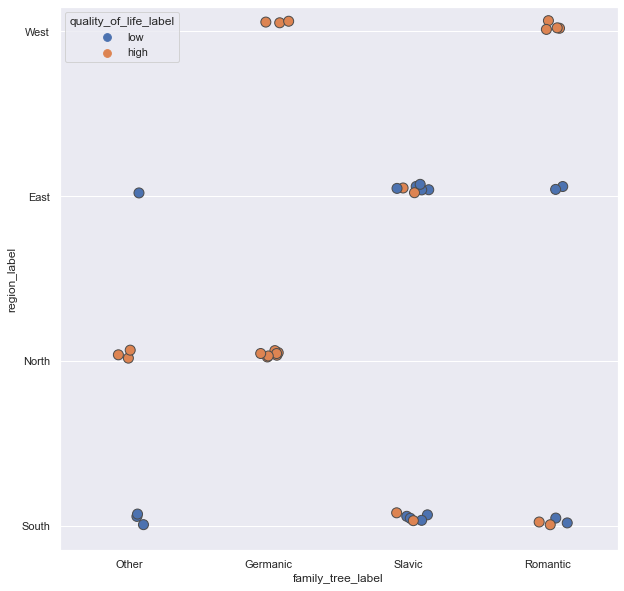

In [58]:
f, ax1 = plt.subplots(1, sharex=True, sharey=False, figsize=(10, 10))

sns.stripplot(data=location_clusters, x = 'family_tree_label', y='region_label', hue='quality_of_life_label', size=10, linewidth=1, ax=ax1)
# sns.stripplot(data=location_clusters, x = 'predicted_cluster', y='region_label', hue='region_label', linewidth=1, ax=ax2)
# sns.stripplot(data=location_clusters, x = 'predicted_cluster', y='quality_of_life_label', hue='quality_of_life_label', linewidth=1, ax=ax3)

for ax in [ax1]:
  for collection in ax.collections:
    dots = collection
    offsets = dots.get_offsets()
    jittered_offsets = offsets + np.random.uniform(0, 0.08, offsets.shape)
    dots.set_offsets(jittered_offsets)

## Reducing family tree label to Slavic and Germanic

In [59]:
covid_europe_gs = covid_europe.set_index('location').join(covid_europe_class)
covid_europe_gs = covid_europe_gs[covid_europe_gs['family_tree_label'].isin(['Slavic','Germanic'])].reset_index()
covid_europe_gs.head()

,location,iso_code,continent,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,family_tree,tourism,region_label,family_tree_label,tourism_label,quality_of_life,quality_of_life_label,health_care,health_care_label,health_care_value
0,Austria,AUT,Europe,2020-01-23,NaN,0.0,NaN,NaN,0.0,NaN,...,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
1,Austria,AUT,Europe,2020-01-24,NaN,0.0,NaN,NaN,0.0,NaN,...,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
2,Austria,AUT,Europe,2020-01-25,NaN,0.0,NaN,NaN,0.0,NaN,...,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
3,Austria,AUT,Europe,2020-01-26,NaN,0.0,NaN,NaN,0.0,NaN,...,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56
4,Austria,AUT,Europe,2020-01-27,NaN,0.0,NaN,NaN,0.0,NaN,...,1,1,West,Germanic,5.0 - 5.5,2,high,2,high,78.56


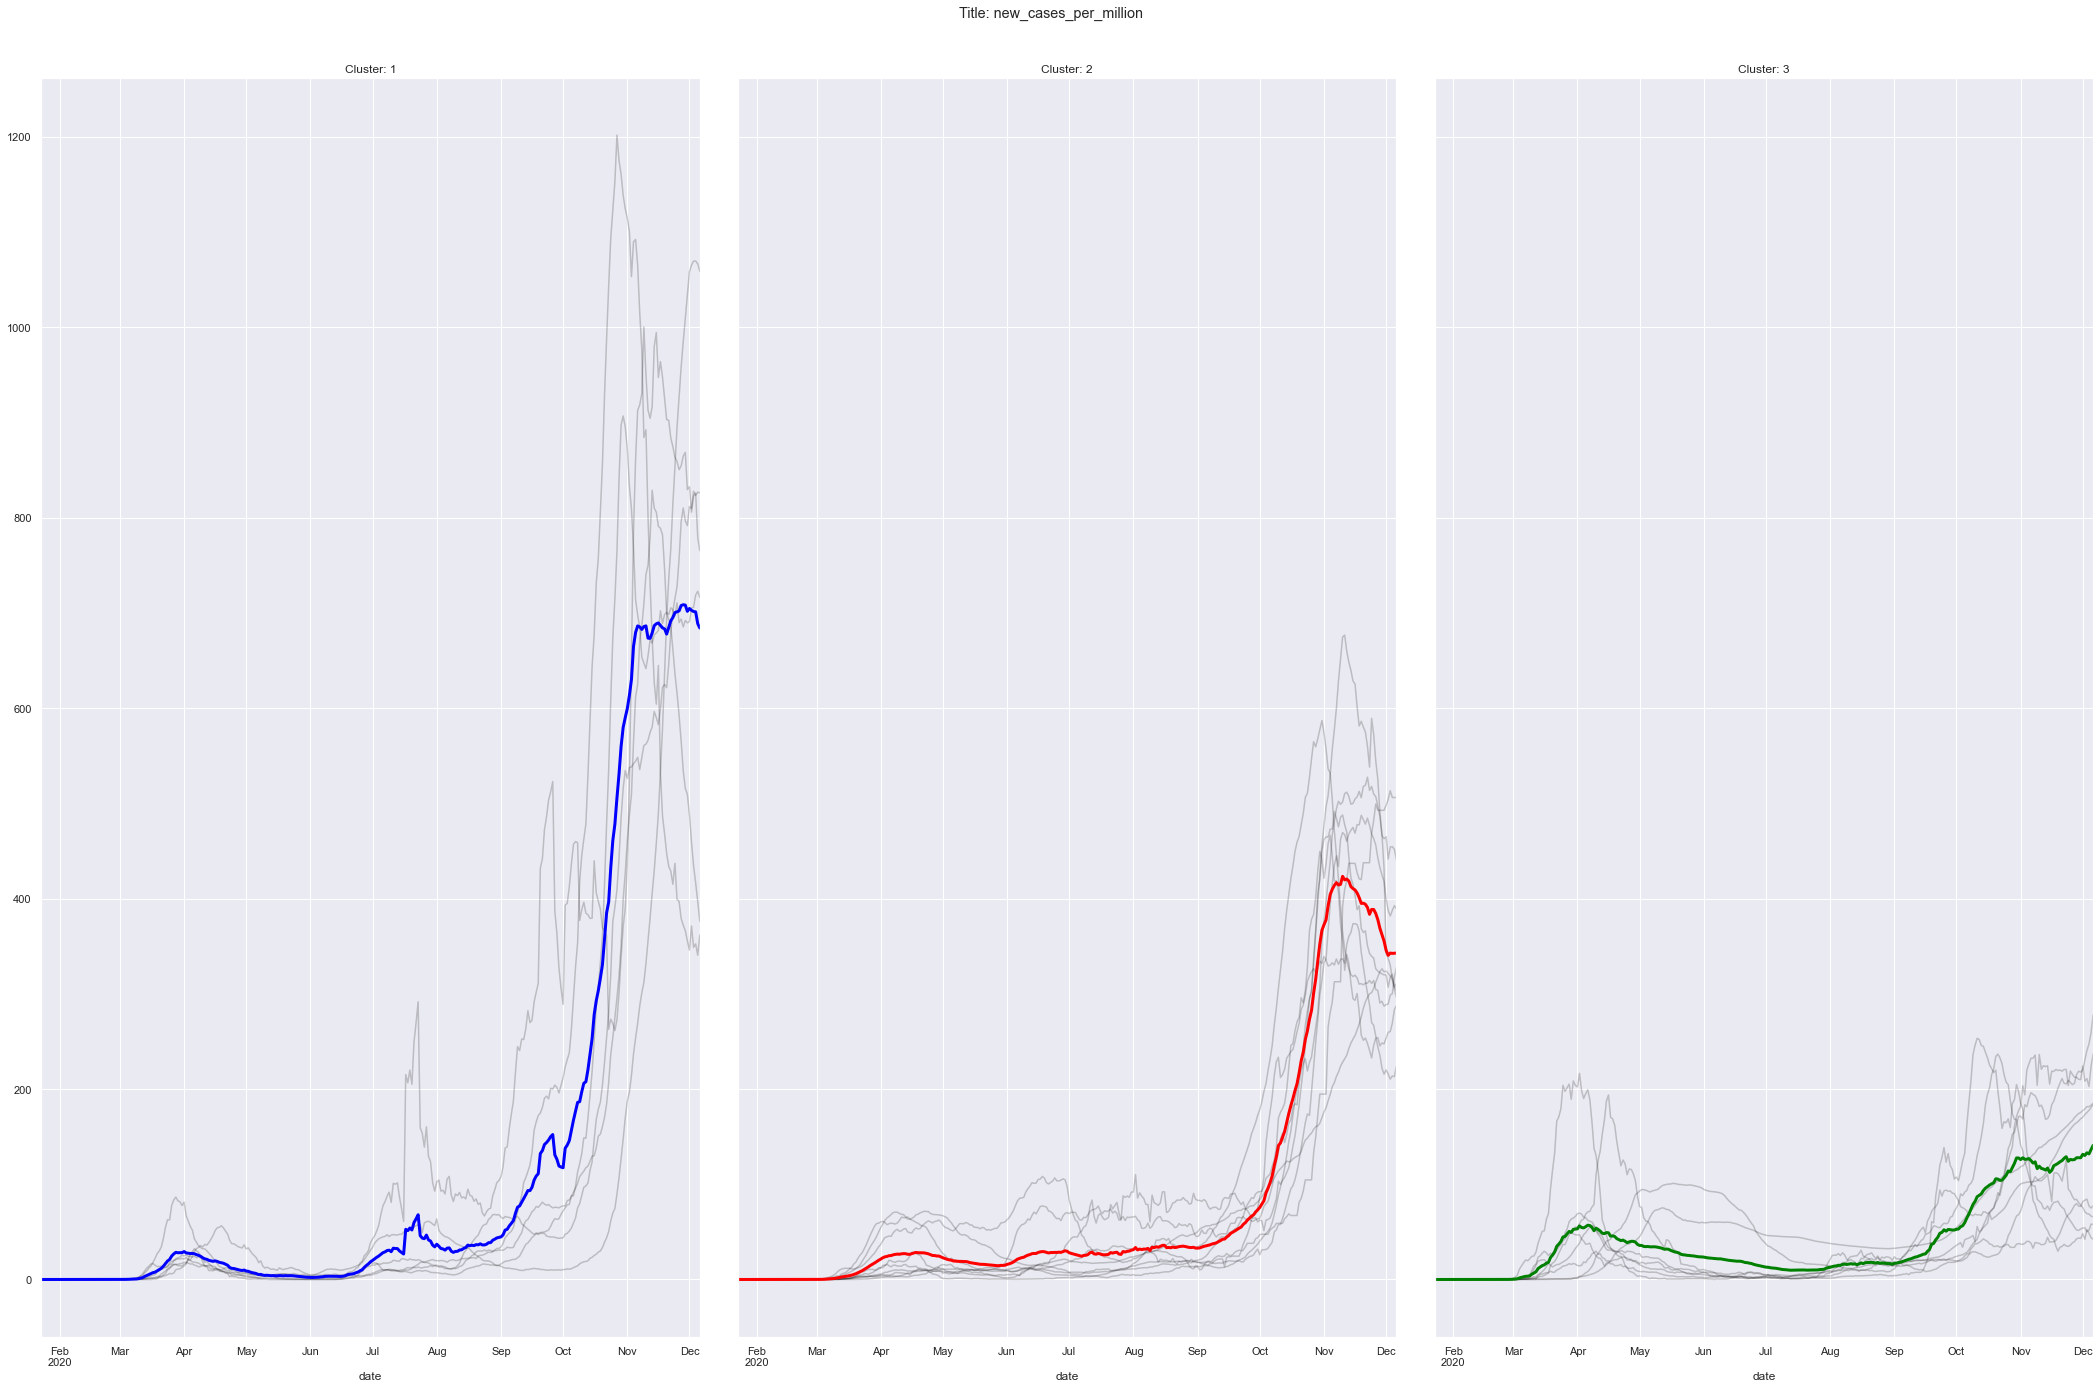

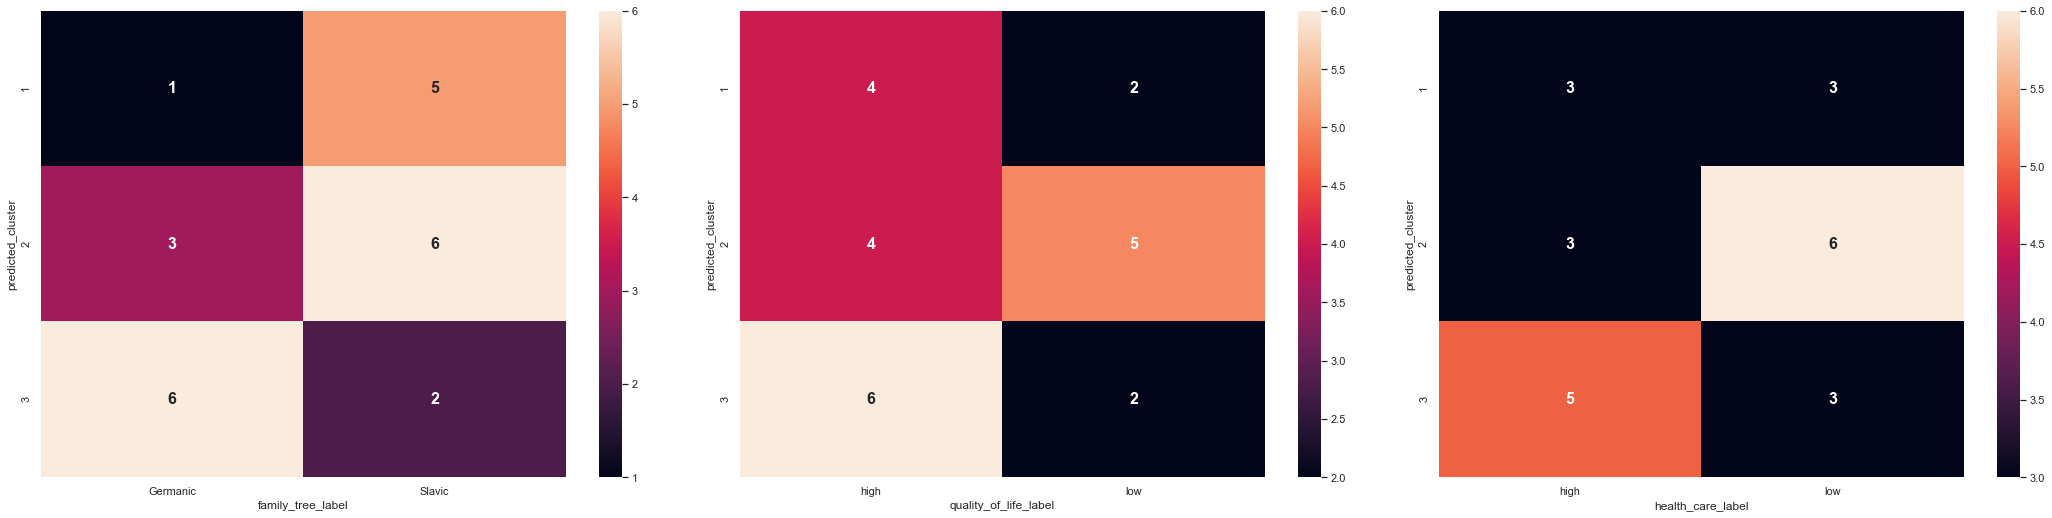

<Figure size 864x864 with 0 Axes>

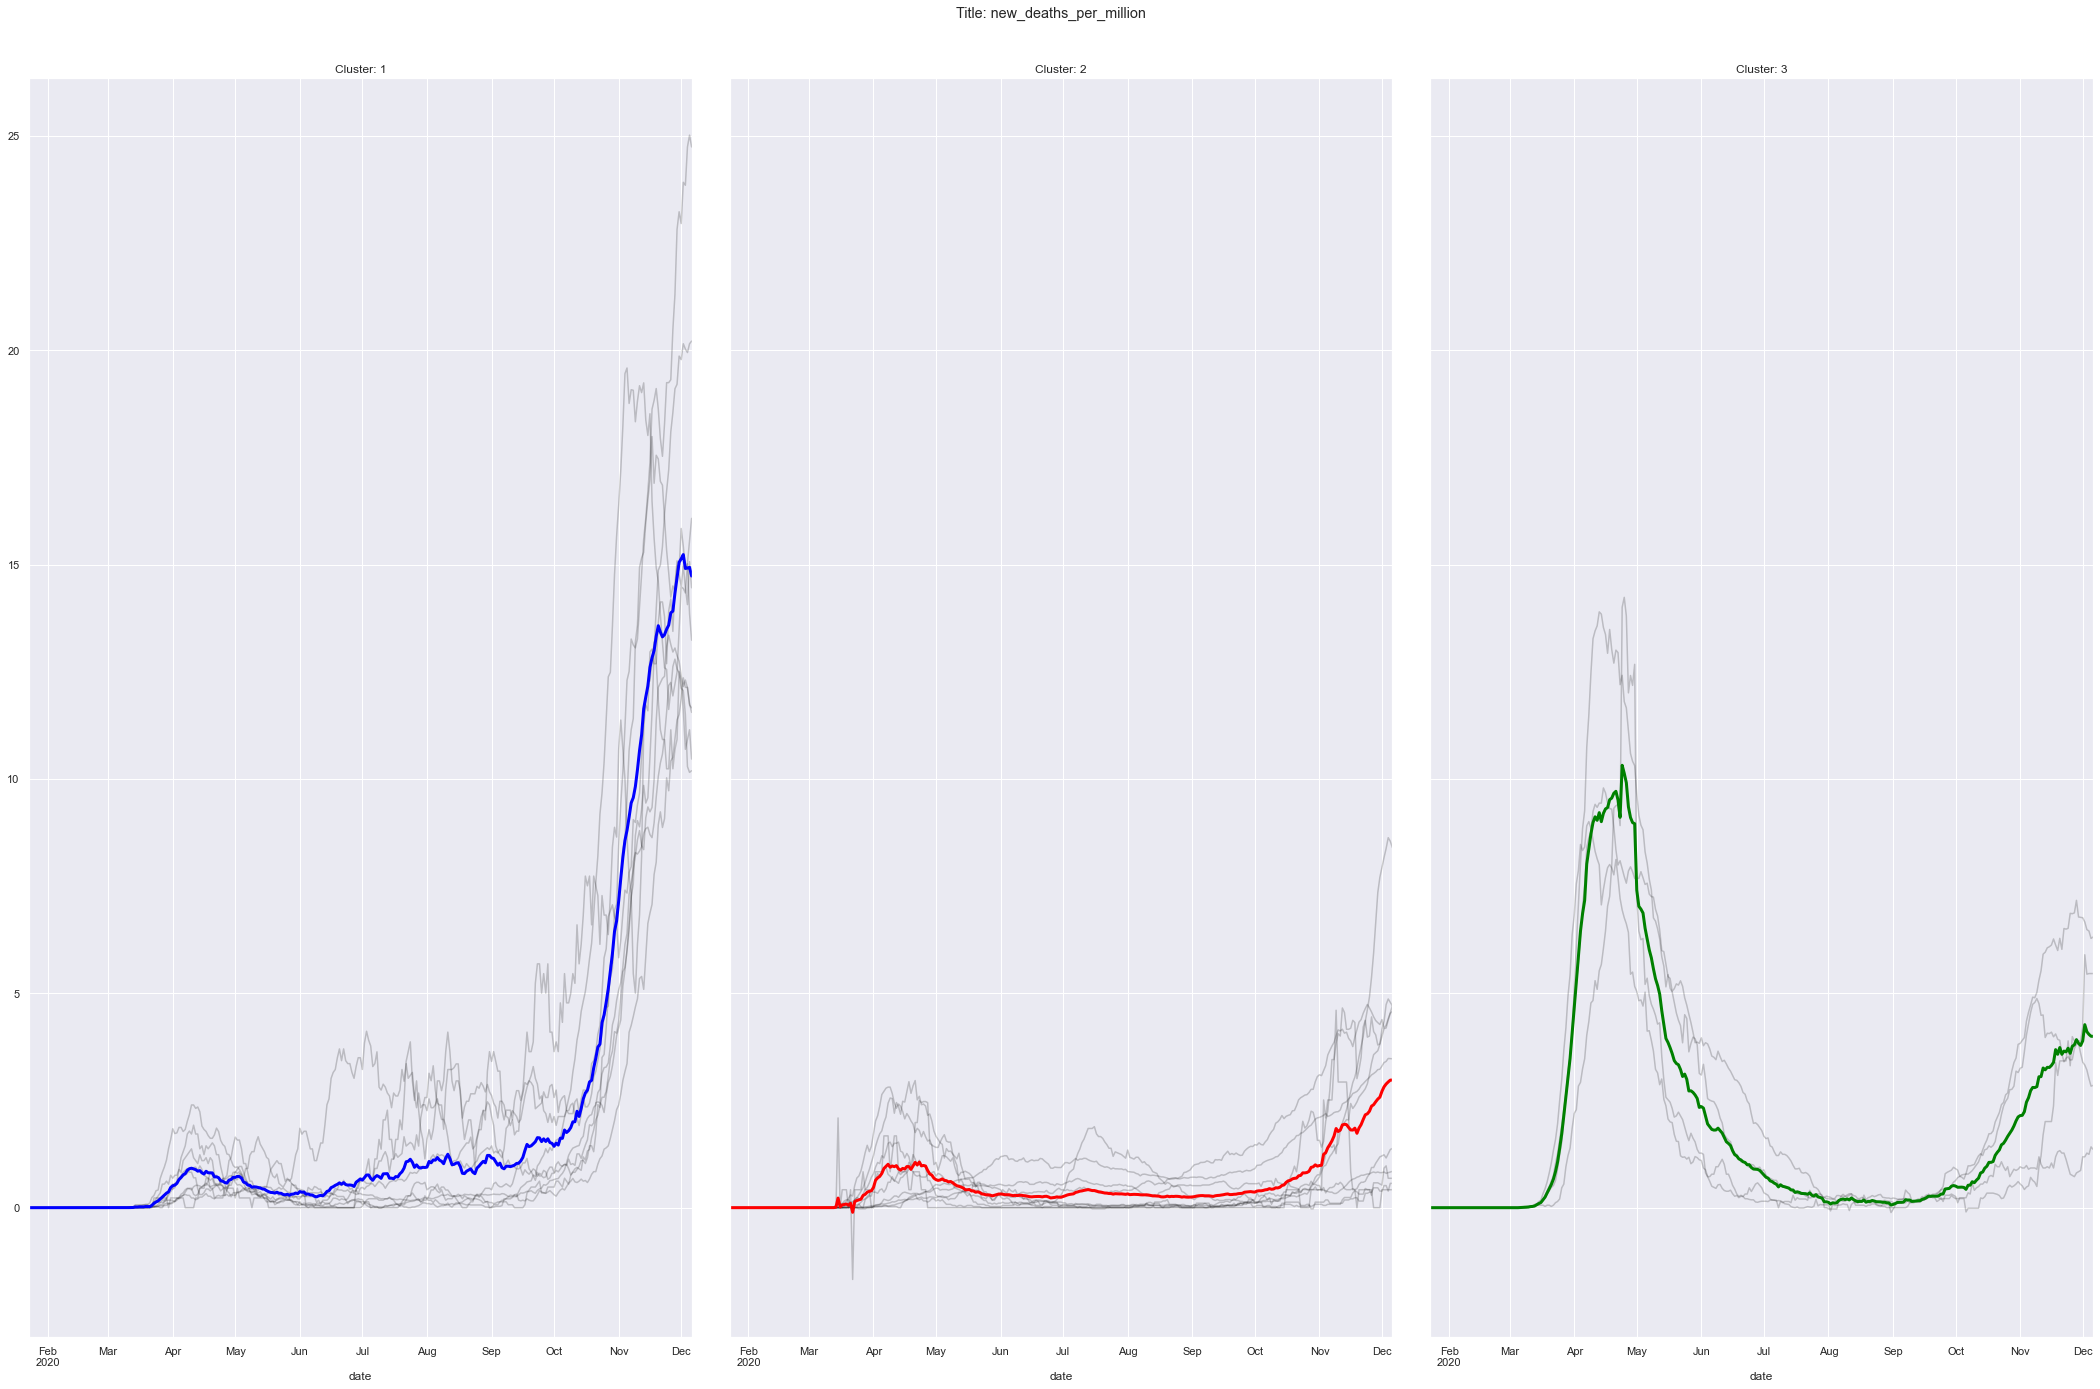

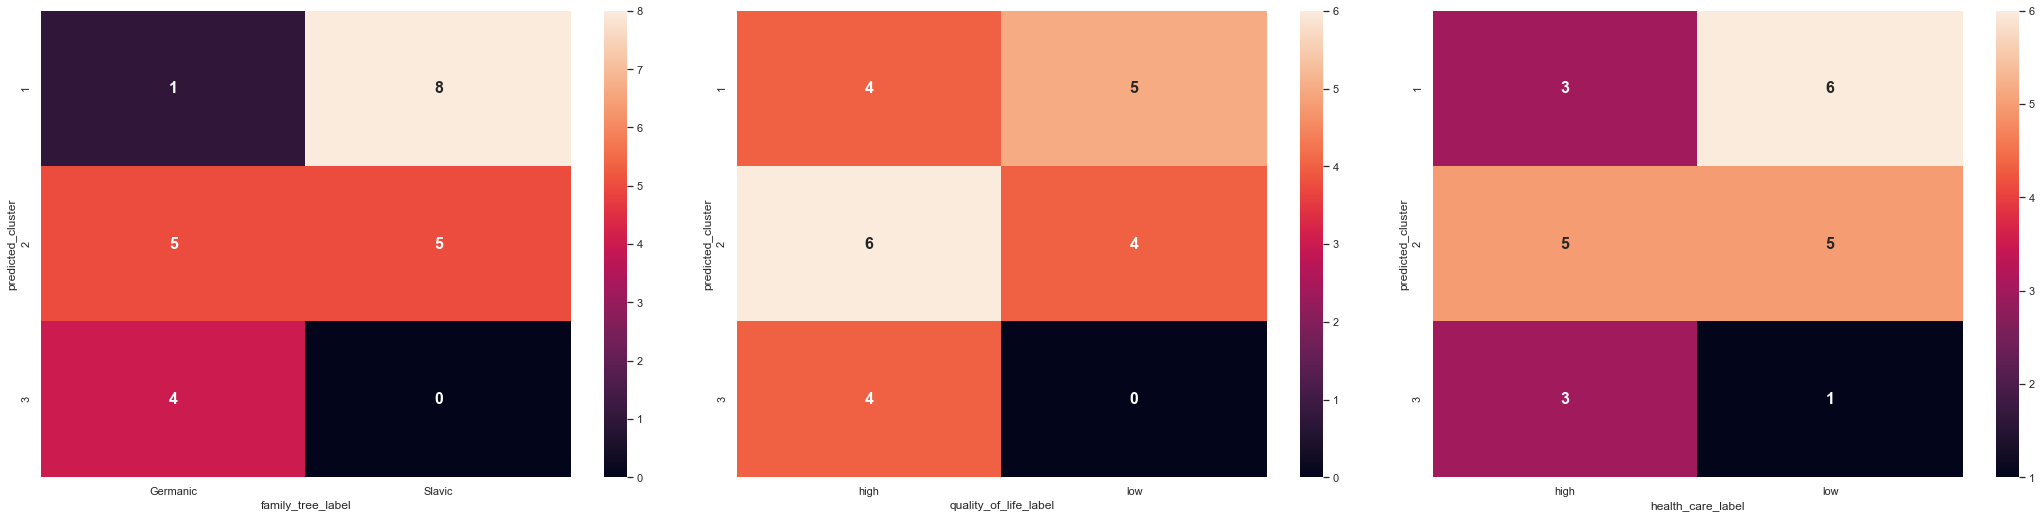

<Figure size 864x864 with 0 Axes>

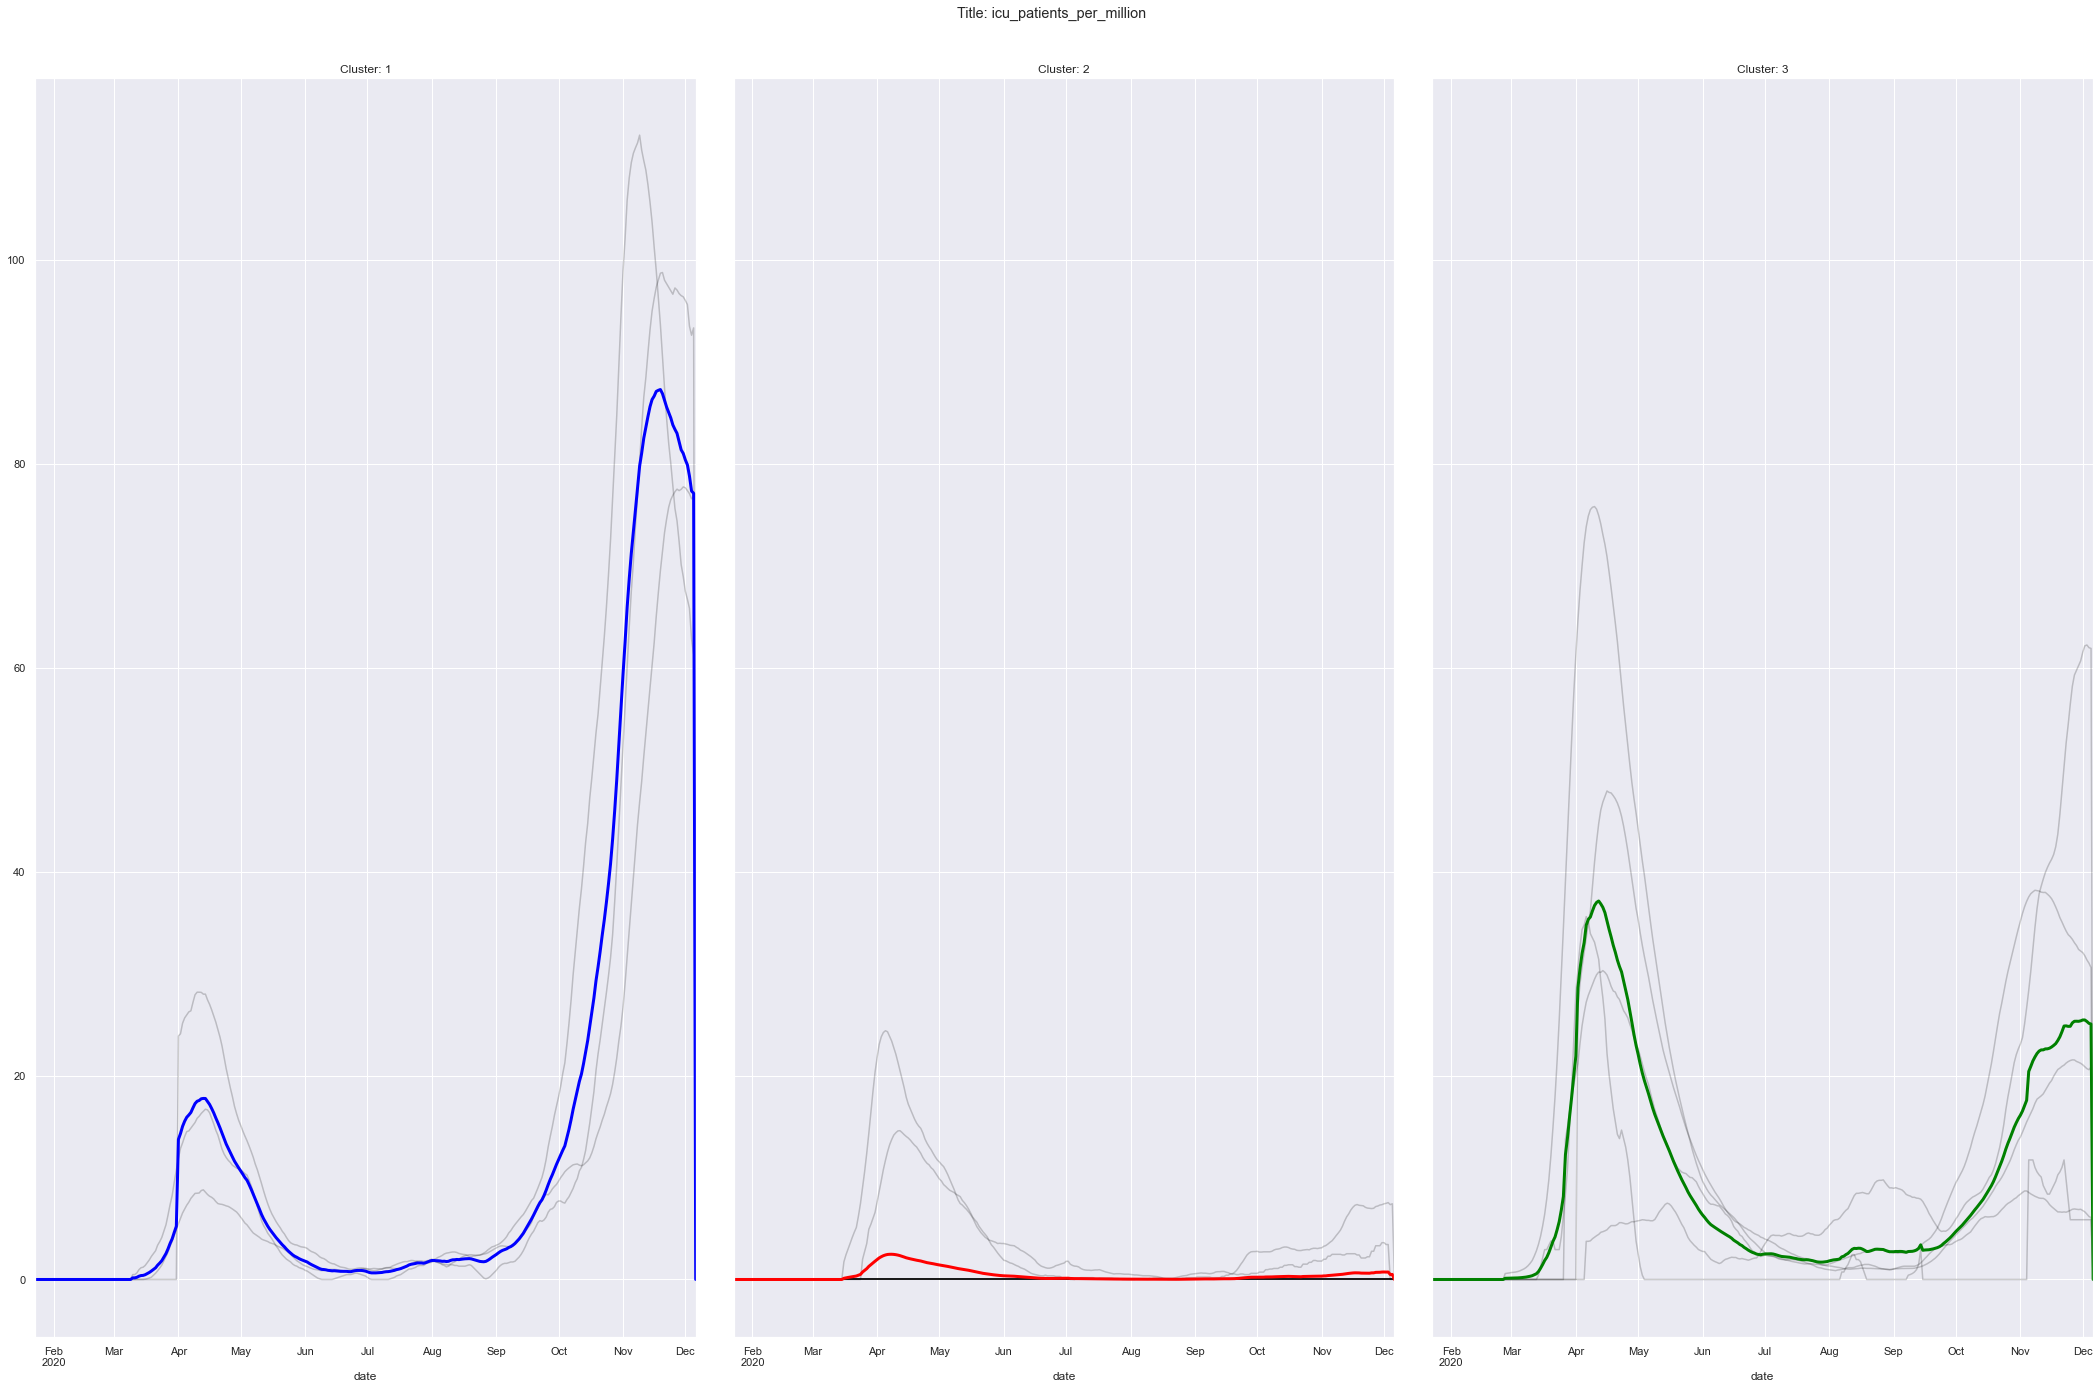

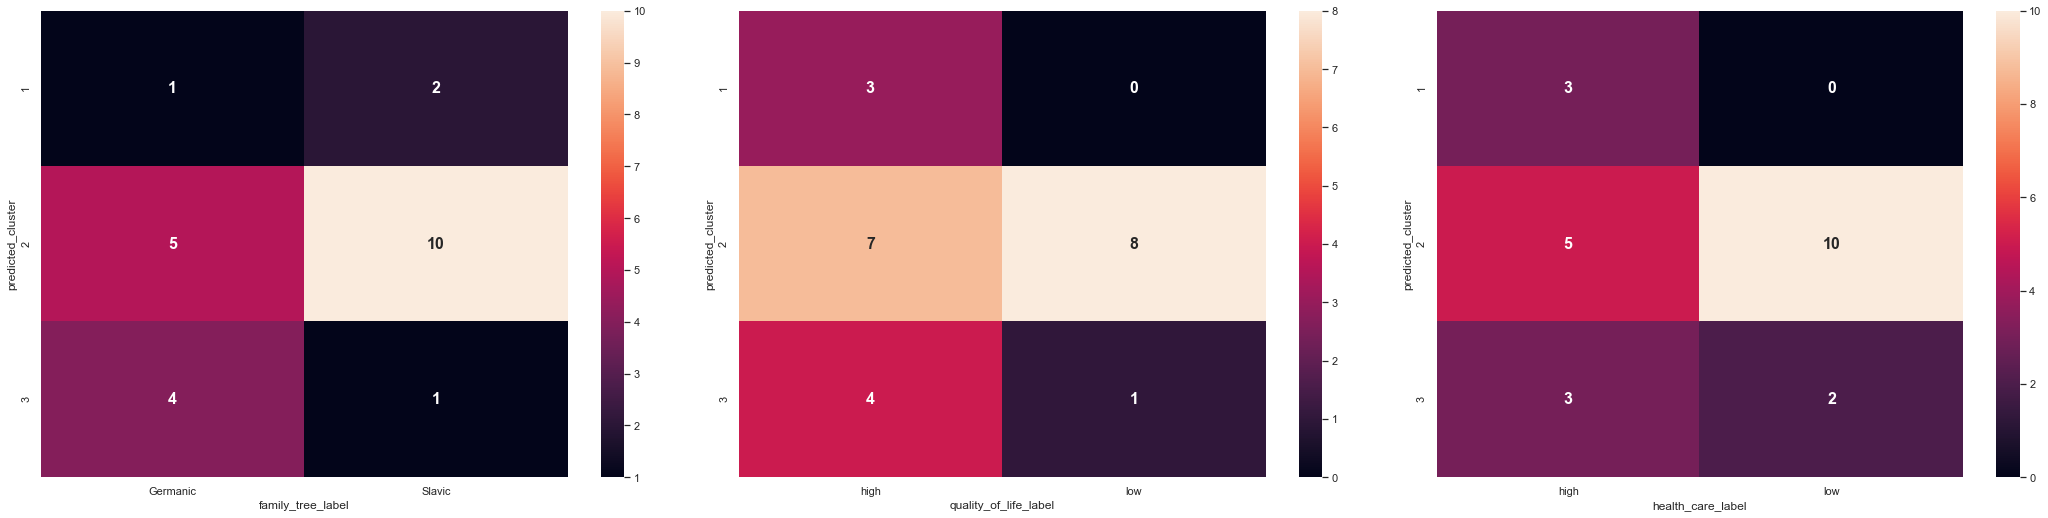

<Figure size 864x864 with 0 Axes>

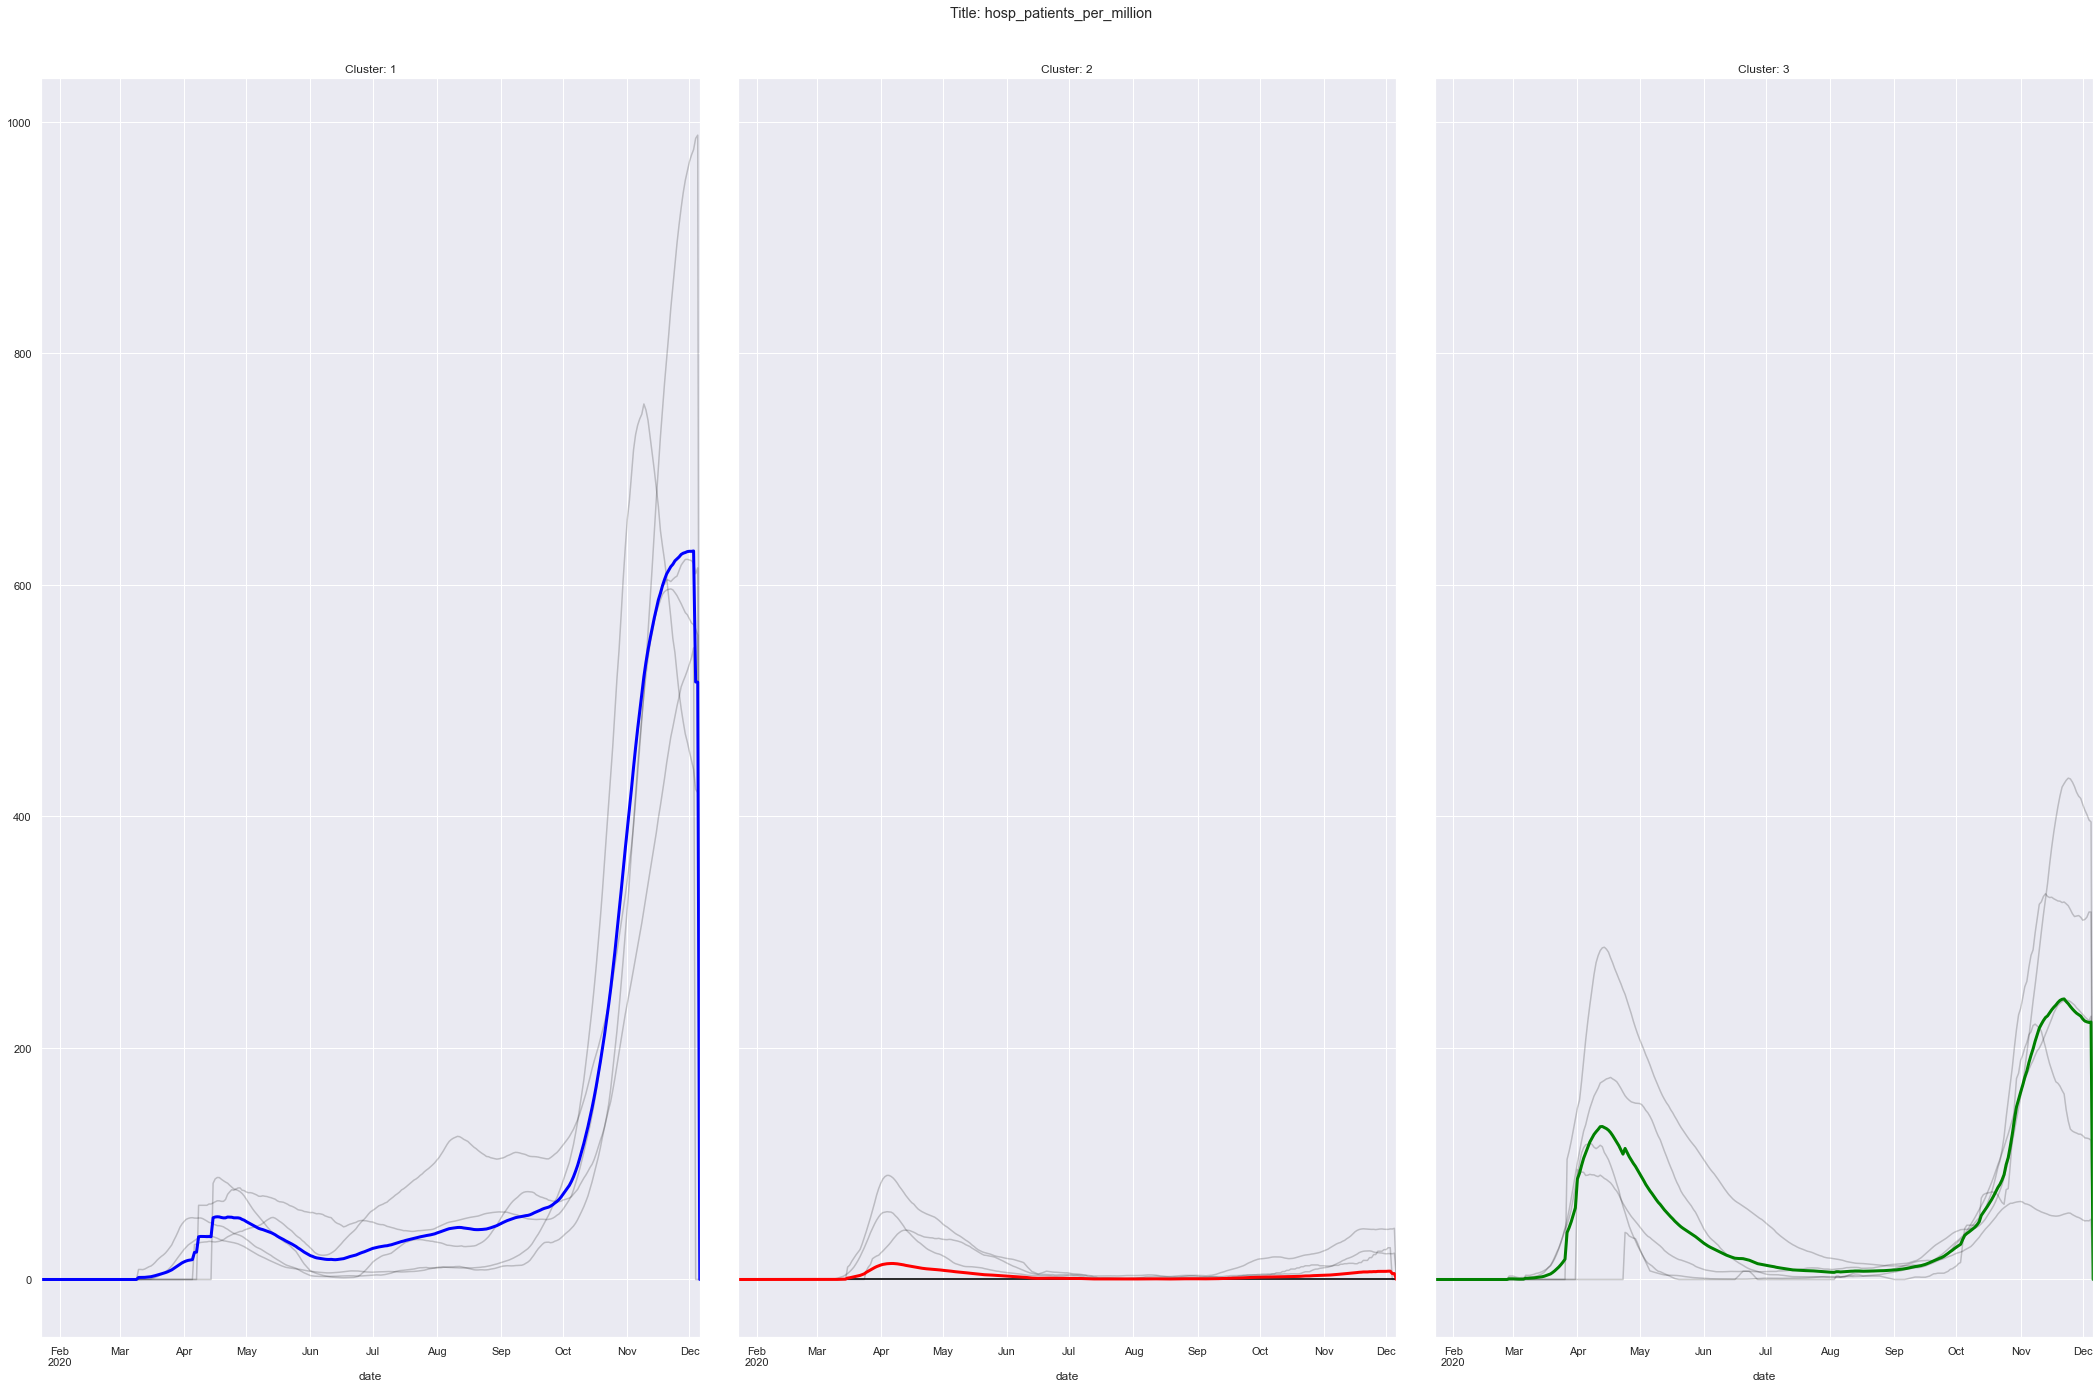

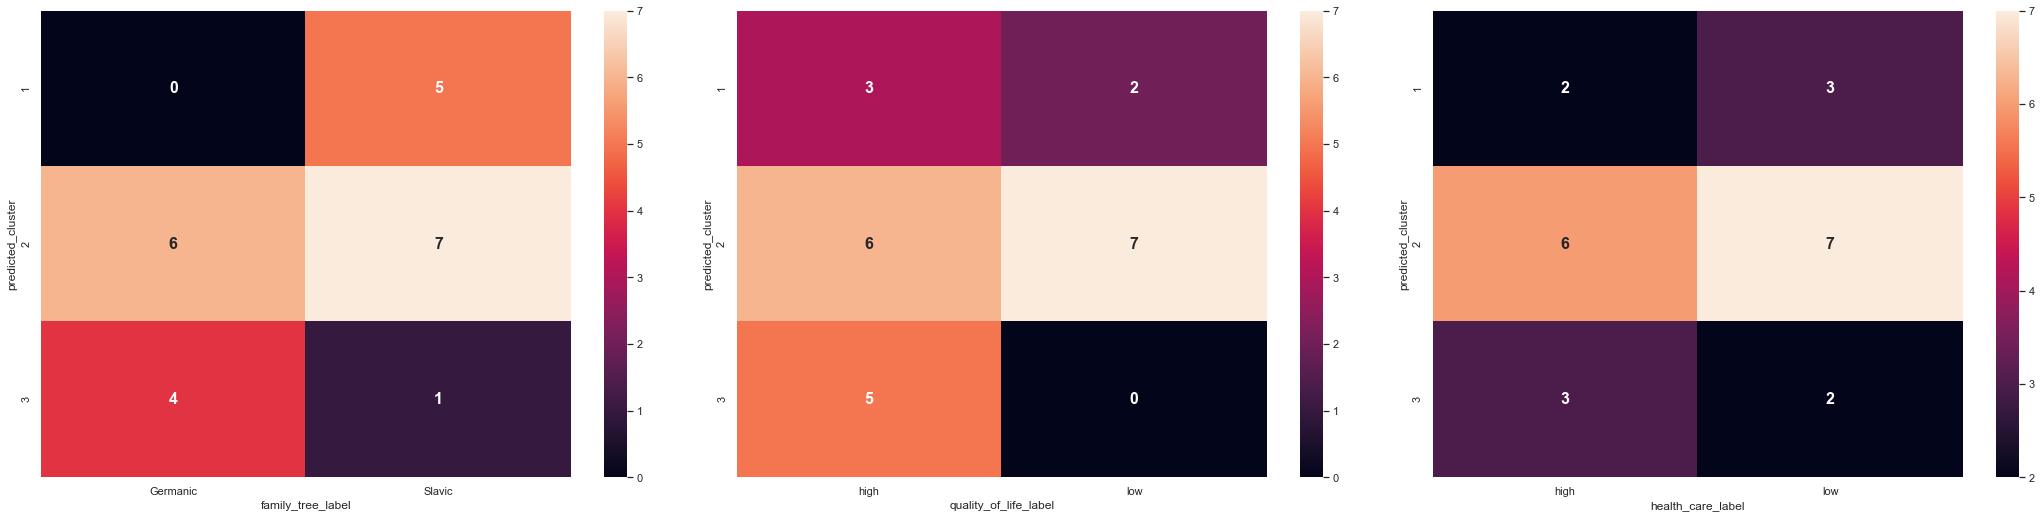

<Figure size 864x864 with 0 Axes>

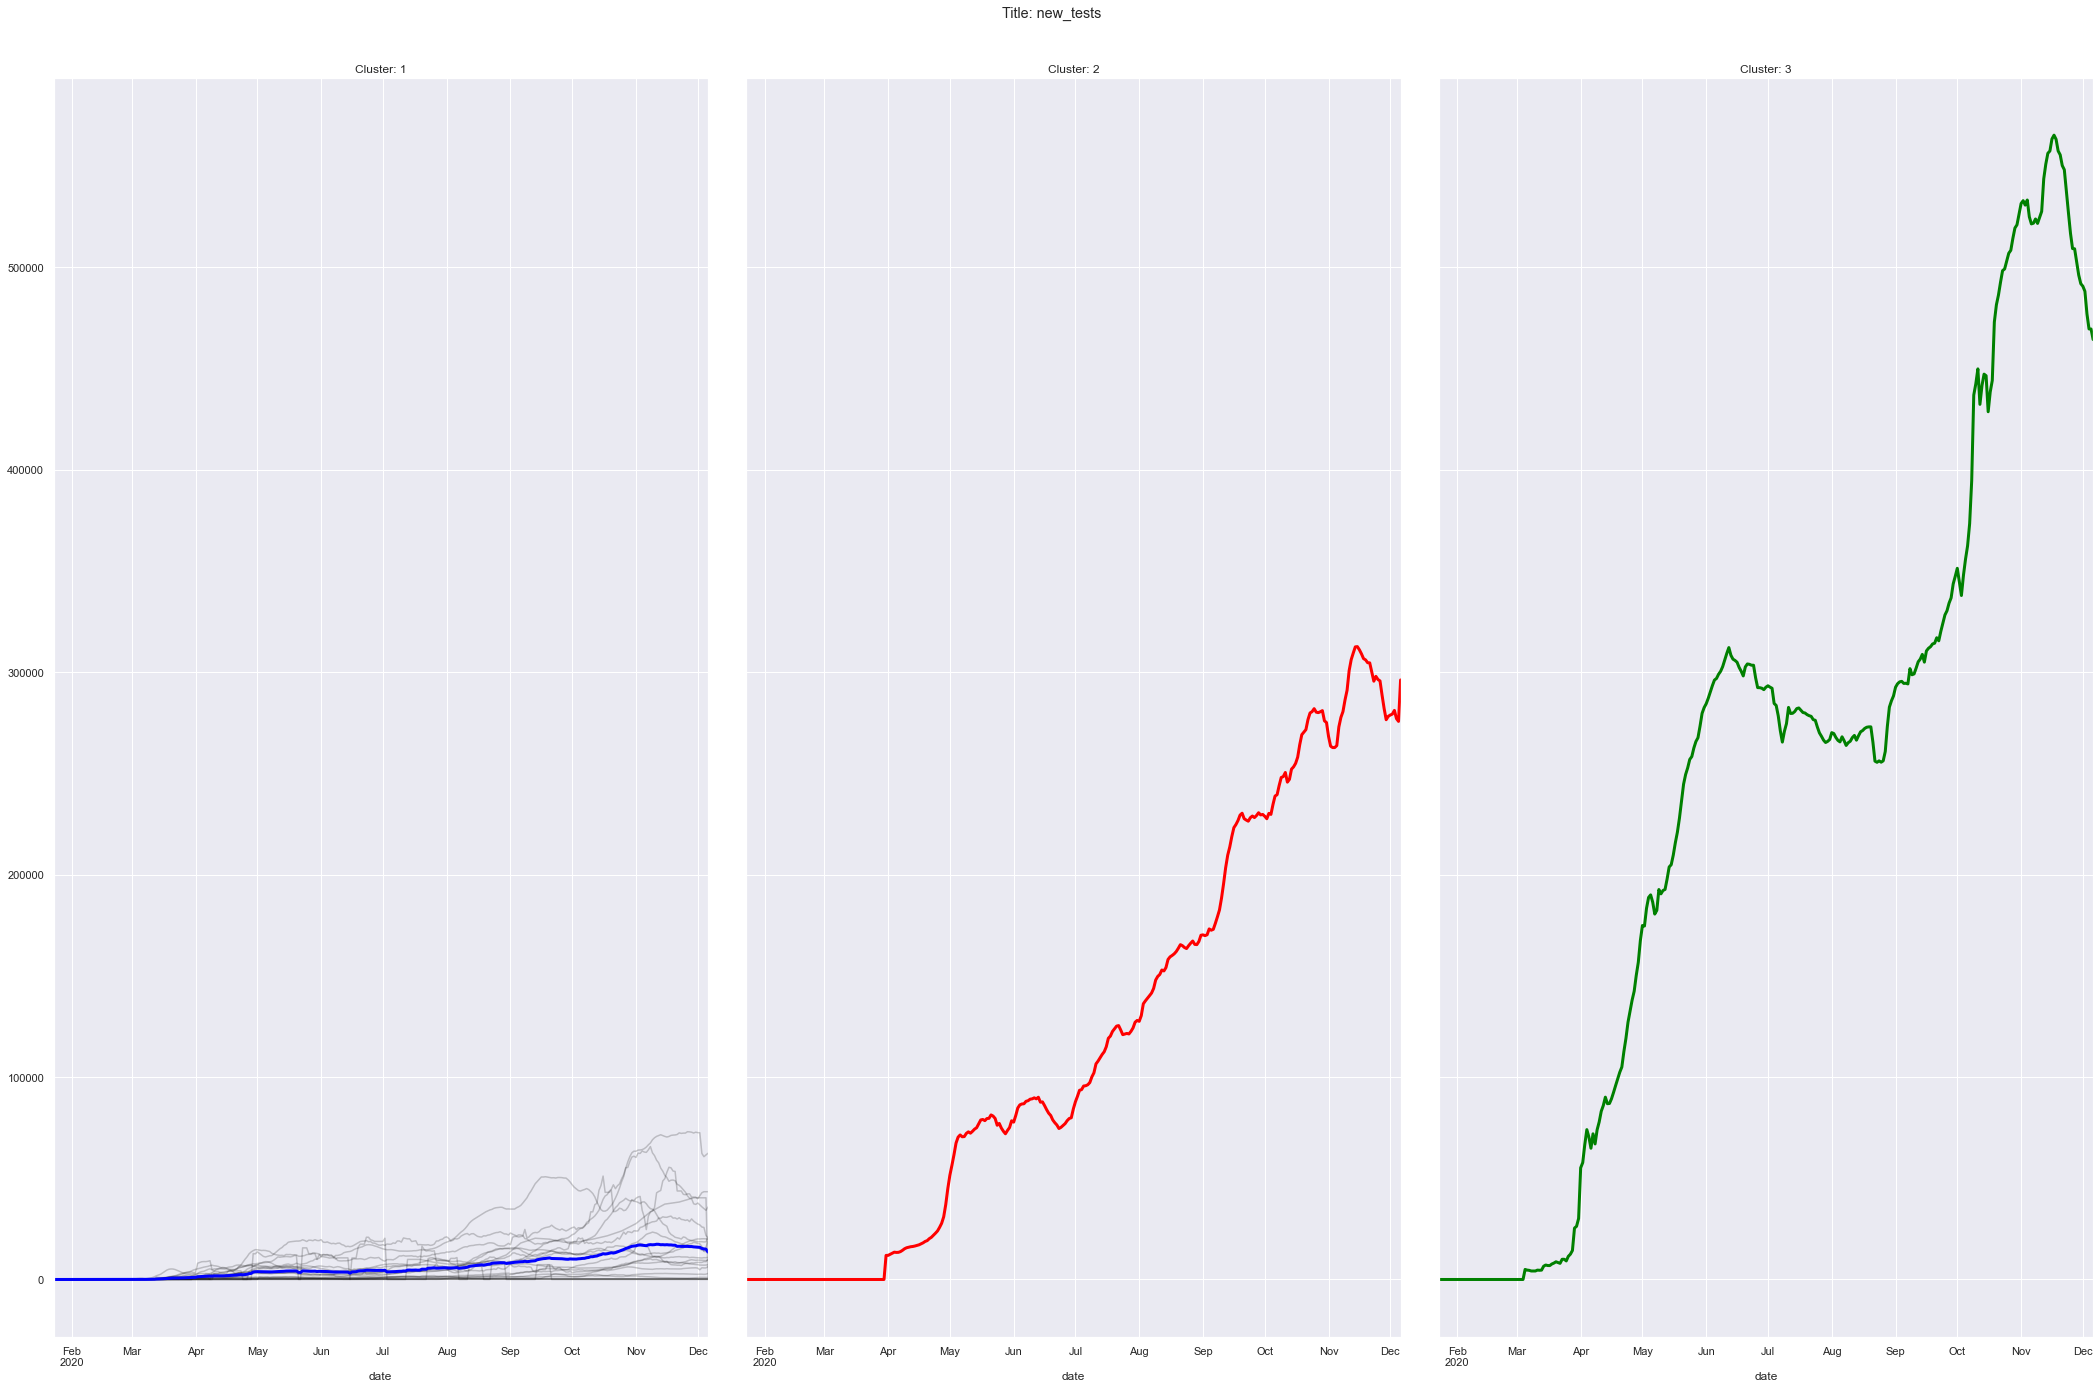

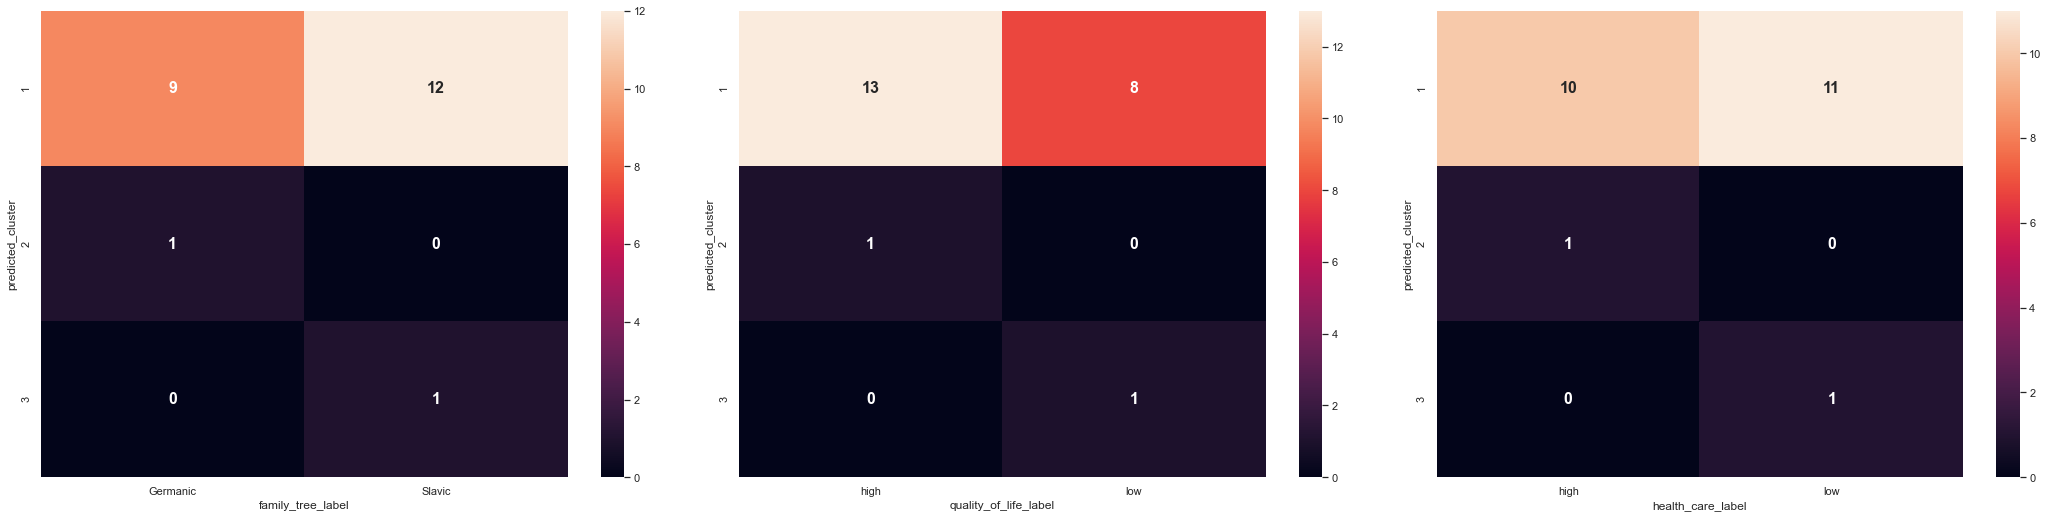

<Figure size 864x864 with 0 Axes>

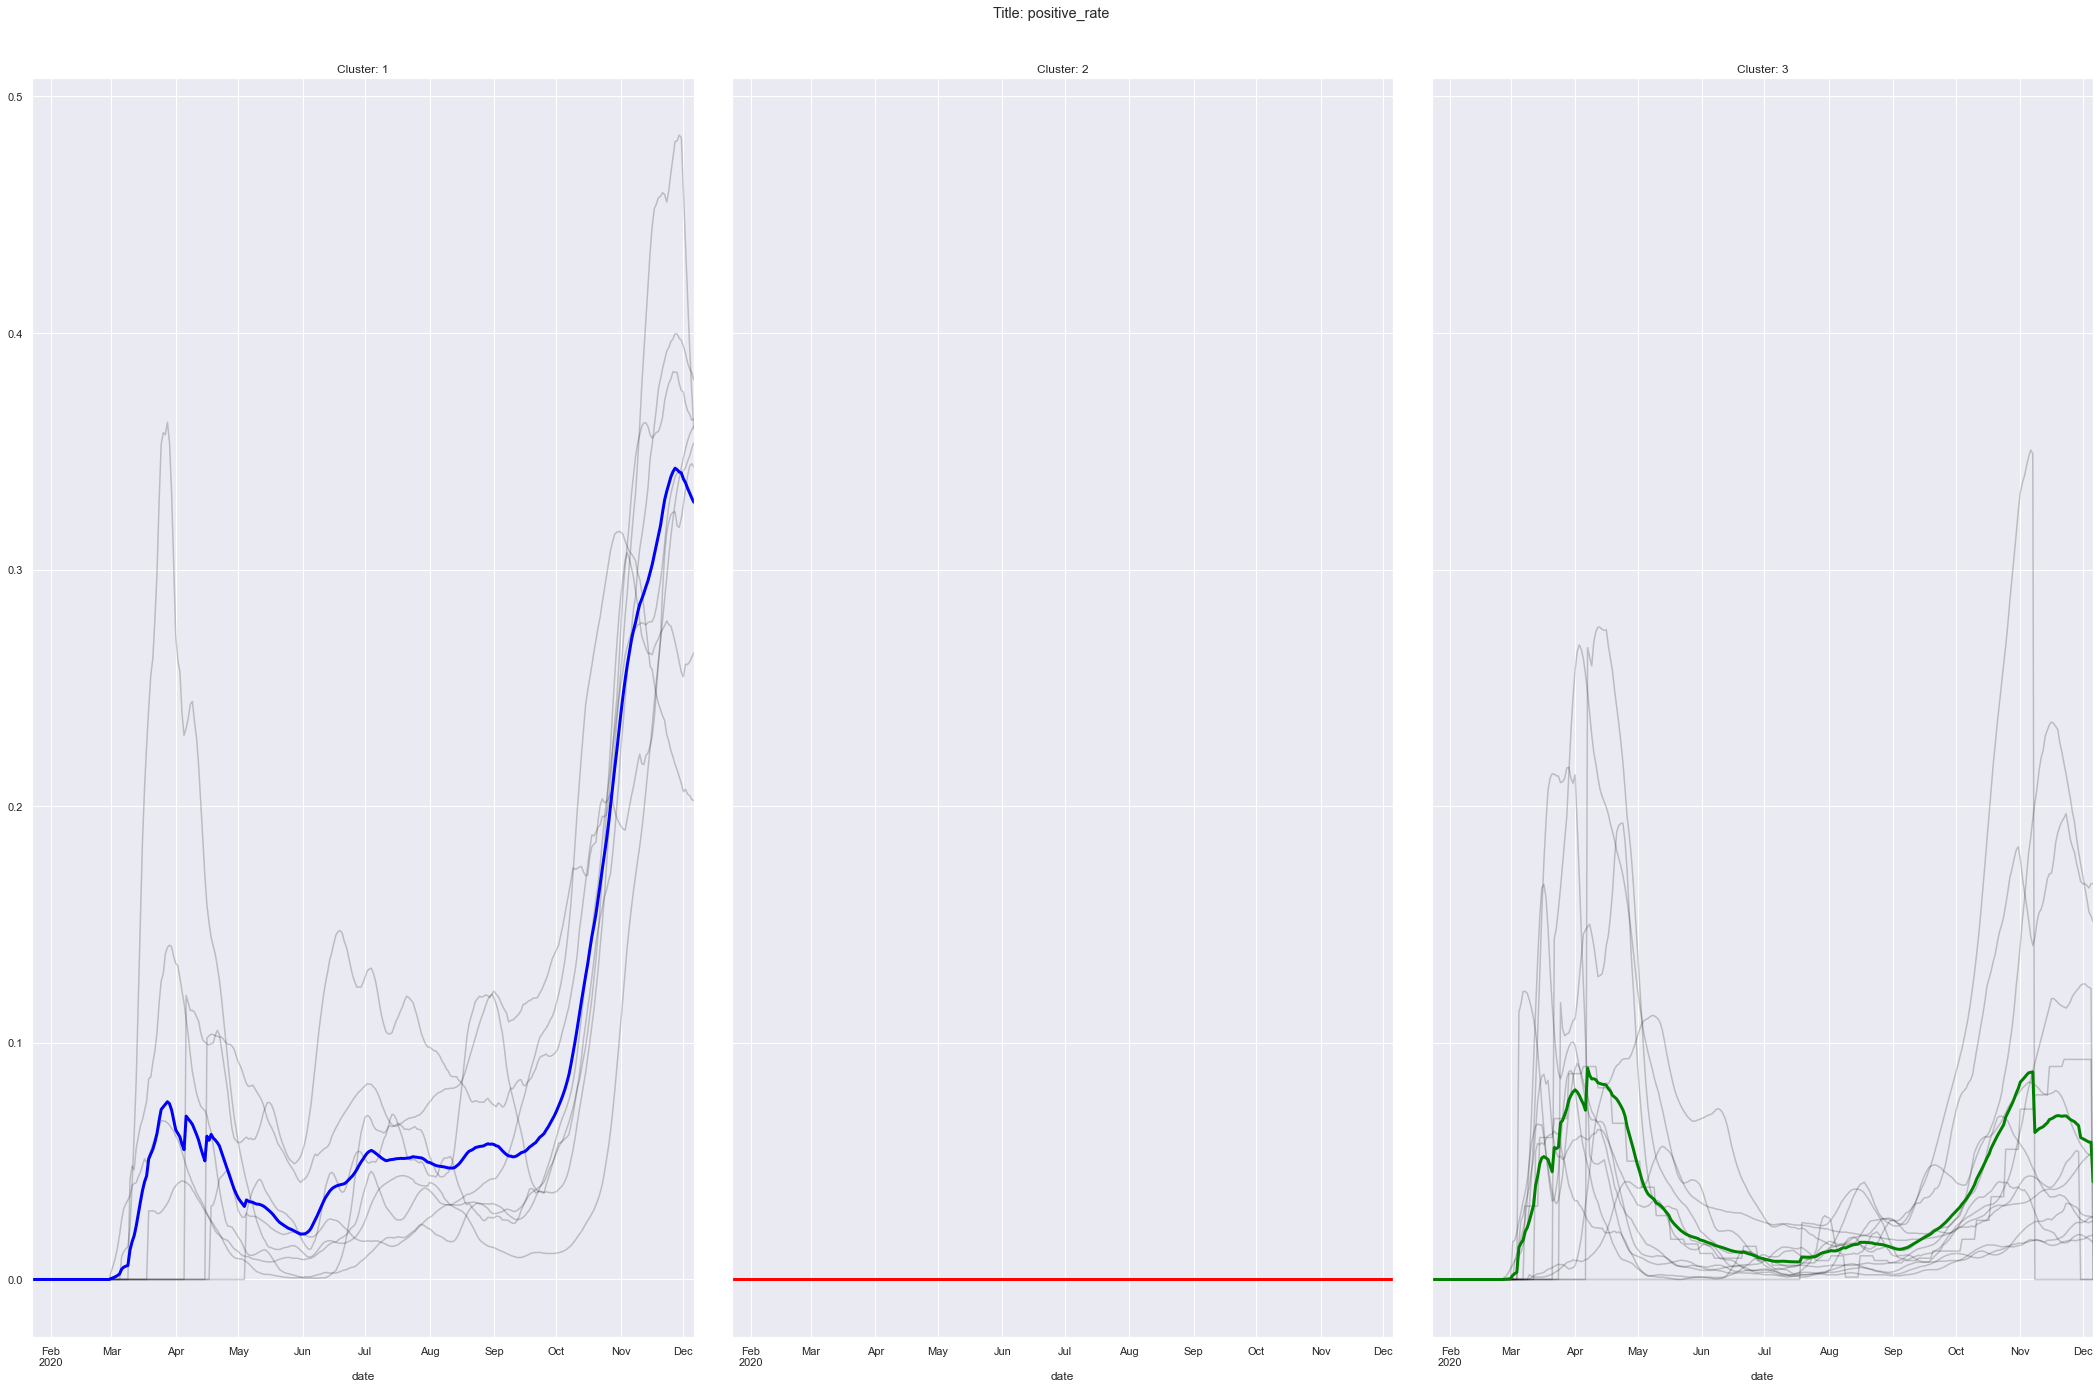

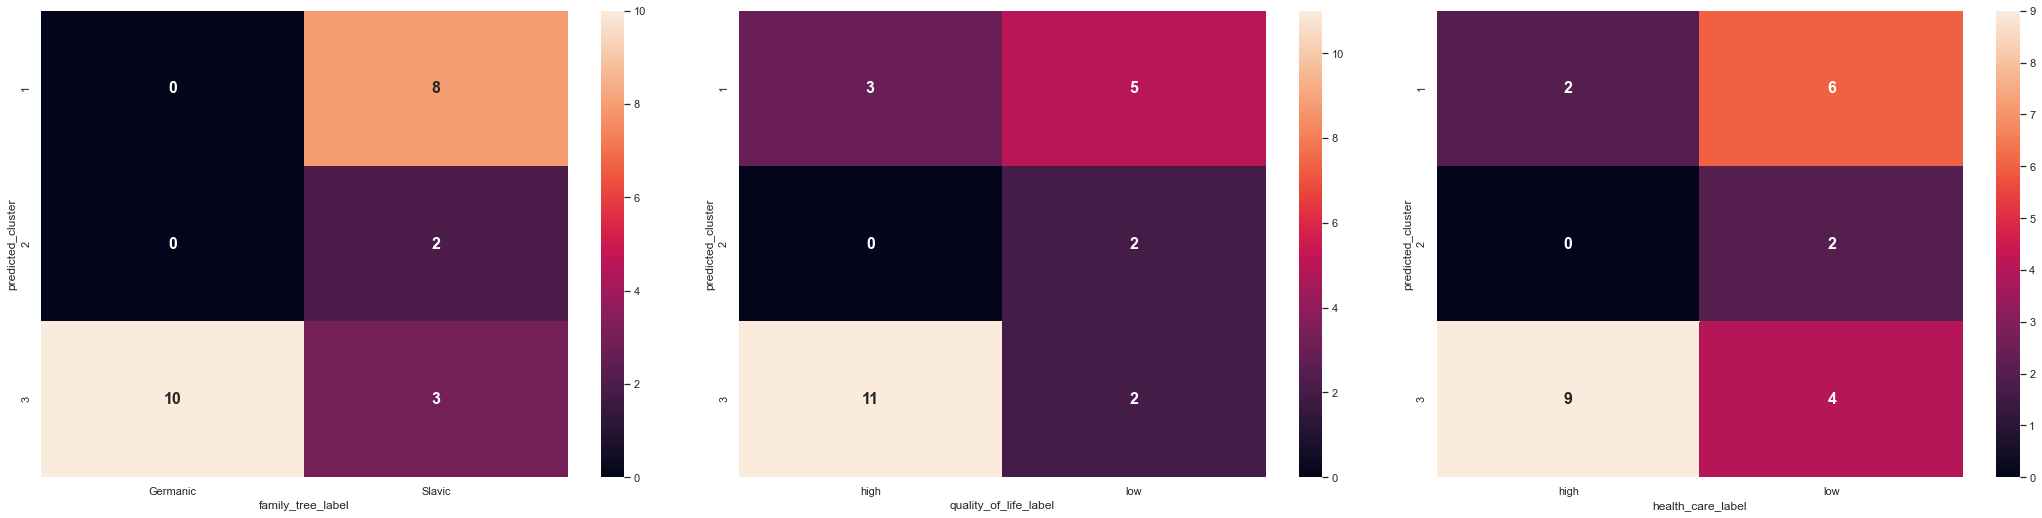

<Figure size 864x864 with 0 Axes>

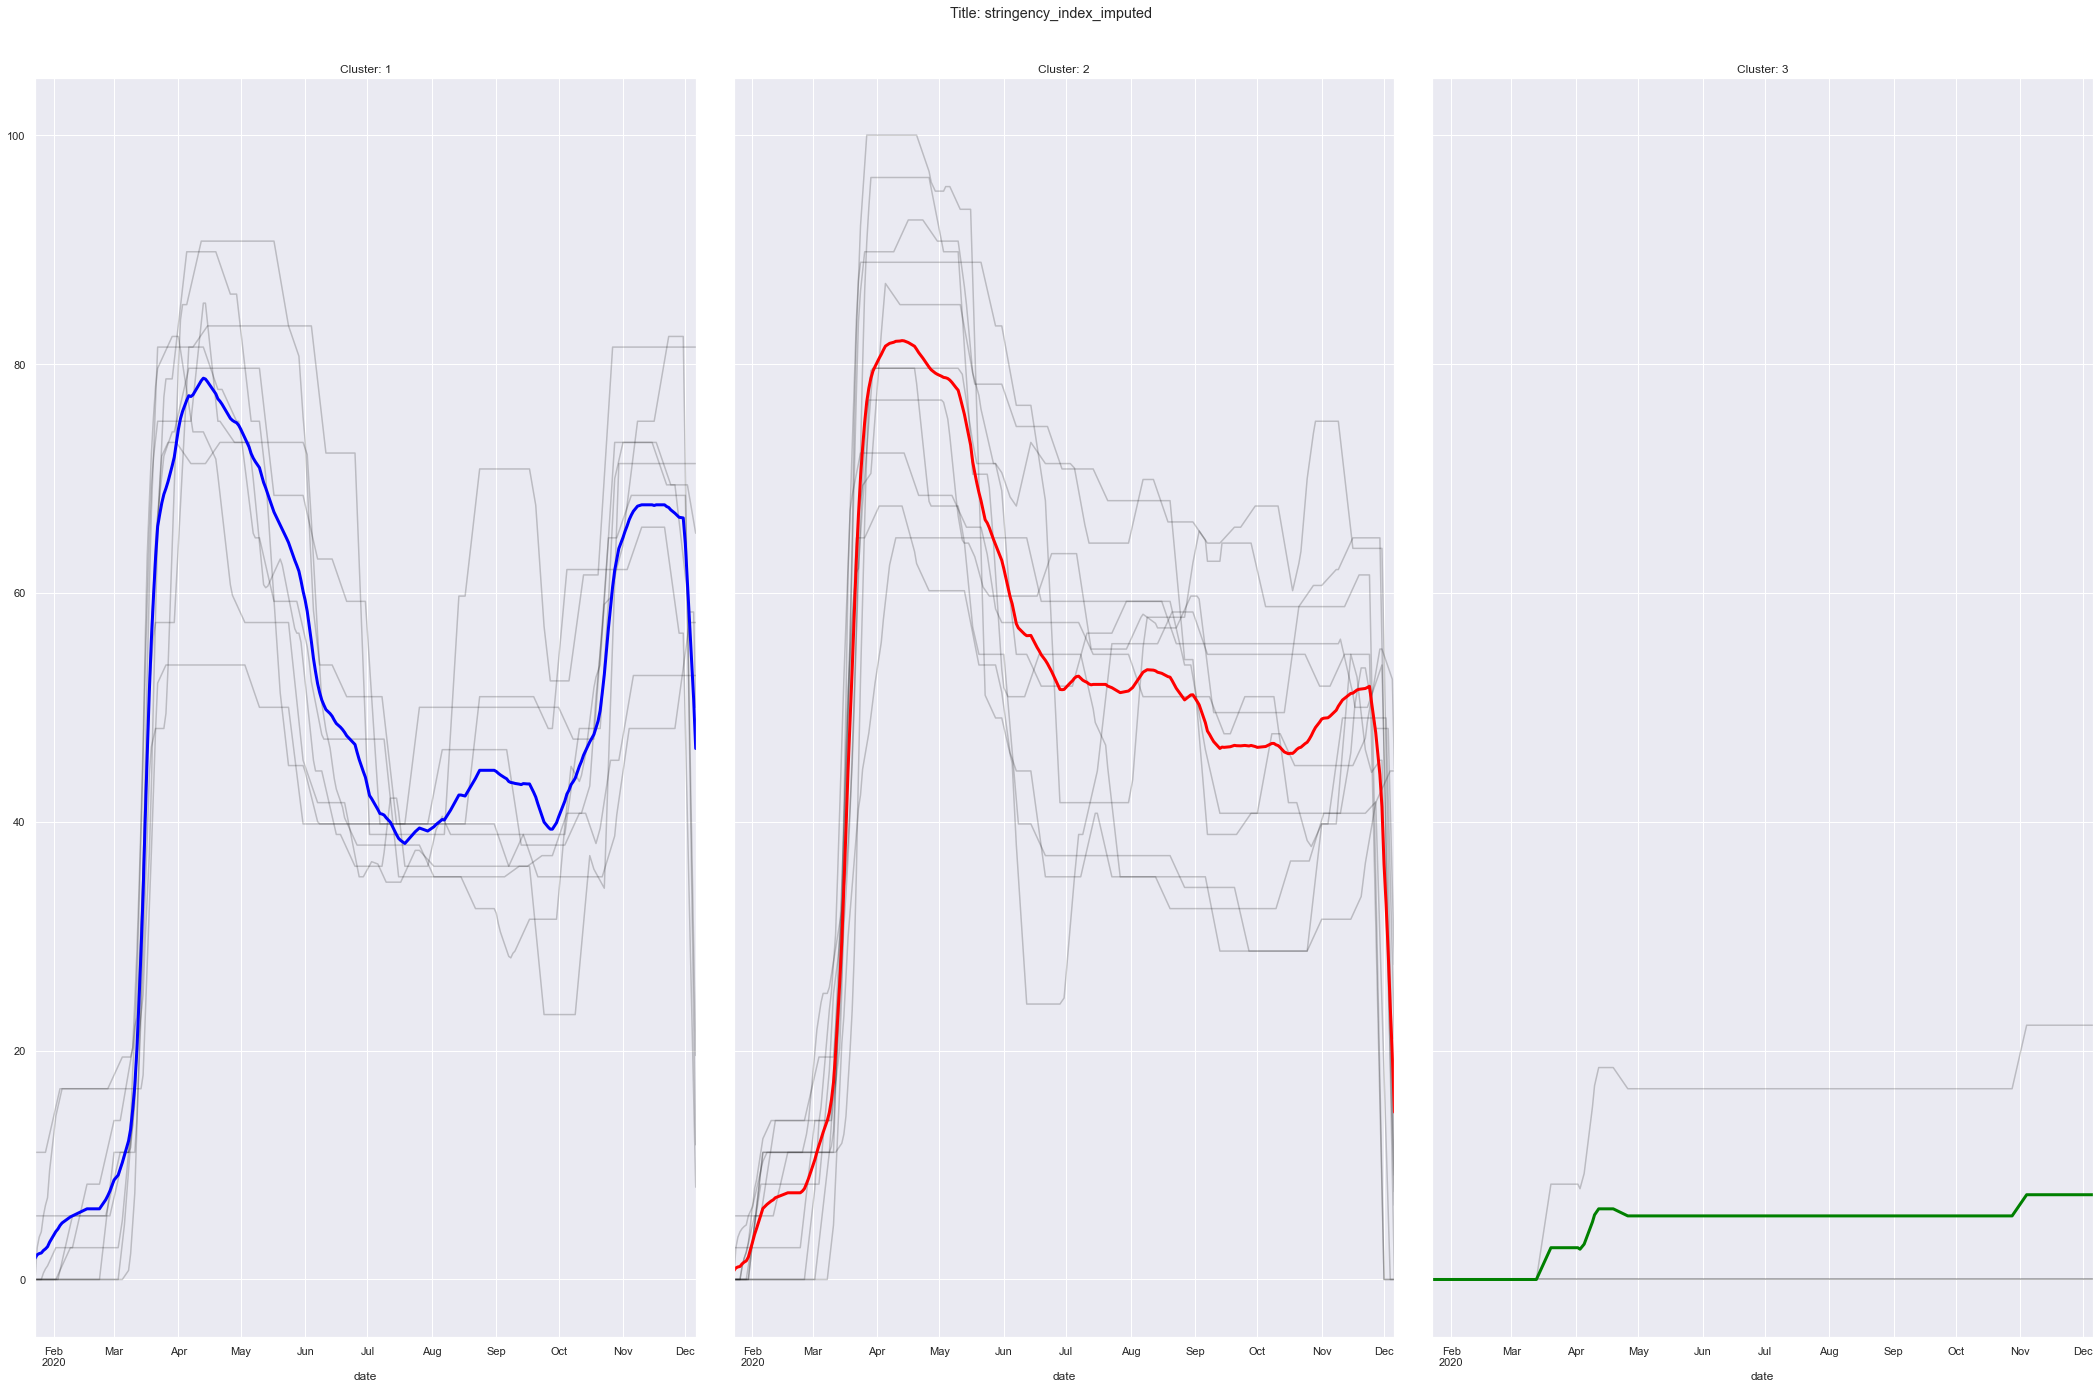

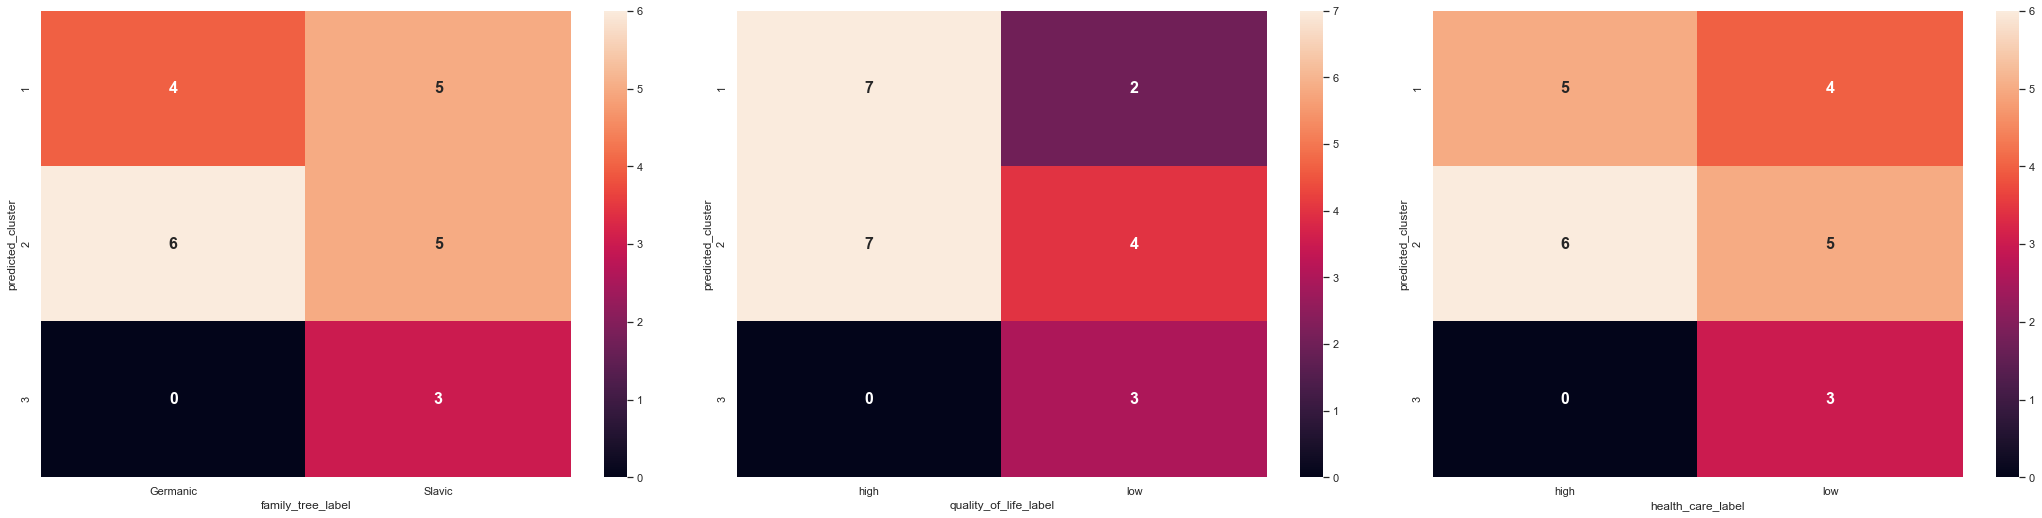

<Figure size 864x864 with 0 Axes>

In [60]:
ts_list = ['new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']

for i in ts_list:
    covid_europe_ts = covid_europe_gs[['location','date','new_cases_per_million','new_deaths_per_million','icu_patients_per_million','hosp_patients_per_million','new_tests','positive_rate','stringency_index_imputed']]
    covid_europe_ts['date']= pd.to_datetime(covid_europe_ts['date'])
    covid_europe_ts = covid_europe_ts.pivot(index='location', columns='date', values=i)
    covid_europe_ts = covid_europe_ts.rolling(7, axis=1, min_periods=1).mean().fillna(0)

    model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10, random_state=1)
    X = to_time_series_dataset(covid_europe_ts.copy())
    labels = model.fit_predict(X)

    clusters = pd.Series(data=labels, index=covid_europe_ts.index)

    colors = ['blue', 'red', 'green']
    names = ['blue cluster', 'red cluster', 'green cluster']

    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(30, 20))
    
    for cluster, ax in zip([0,1,2],[ax1,ax2,ax3]):
        data = covid_europe_ts.loc[clusters[clusters == cluster].index]
        data.T.plot(legend=False, alpha=.2,color='black', ax=ax)
        data.mean(axis=0).plot(linewidth=3., color=colors[cluster], ax=ax)
        ax.set_title("Cluster: " + str(cluster + 1))
    f.suptitle('Title: ' + i)
    plt.tight_layout(pad=3.0)
    # plt.show()

    location_cluster = {'location': covid_europe_ts.index, 'predicted_cluster': 1 + labels}
    location_cluster = pd.DataFrame(location_cluster)
    location_clusters = location_cluster.set_index('location').join(covid_europe_class)
    location_clusters = location_clusters.reset_index()
    
    f, (ax5, ax6, ax7) = plt.subplots(1, 3, figsize=(30,8))
    annot_kws={'fontsize':16, 'weight': 'bold'}
    
    cluster_list = ['family_tree_label', 'quality_of_life_label','health_care_label']
    for i, ax in zip(cluster_list,[ax5,ax6,ax7]):
        ct_cluster = pd.crosstab(index=location_clusters['predicted_cluster'], columns=location_clusters[i])
        sns.heatmap(ct_cluster, annot = True, ax=ax, annot_kws=annot_kws)
    plt.tight_layout(pad=3.0) 
    plt.show()
    plt.subplots_adjust(bottom = 0.2);

In [73]:
fig = make_subplots(rows=2, cols=2, start_cell="top-left")

fig = px.treemap(covid_europe_gs.sort_values(by='new_cases_per_million', ascending=False).reset_index(drop=True), 
                 path=['family_tree_label','location'], values="new_cases_per_million", height=500,
                 title='Number of Confirmed Cases',
                 color='family_tree_label',
                 color_discrete_map={'Germanic':'4f2c1d', 'Slavic':'FF7300'})

fig.data[0].textinfo = 'label+text+value'
fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))
fig.update_traces(textfont=dict(
        size=20,
        color="white"
    ))

fig

In [64]:
fig = make_subplots(rows=2, cols=2, start_cell="top-left")

fig = px.treemap(covid_europe_gs.sort_values(by='new_cases', ascending=False).reset_index(drop=True), 
                 path=['family_tree_label','location'], values="new_cases", height=500,
                 title='Number of Confirmed Cases',
                 color='family_tree_label',
                 color_discrete_map={'Germanic':'4f2c1d', 'Slavic':'FF7300'})

fig.data[0].textinfo = 'label+text+value'
fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))
fig.update_traces(textfont=dict(
        size=20,
        color="white"
    ))

fig